<a href="https://colab.research.google.com/github/HarlinLee/cogsci-missed-connections/blob/main/abstract_content_analysis_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import gensim
from gensim.utils import simple_preprocess

In [ ]:
from google.colab import drive

drive.mount('/content/drive') 
DRIVE_PATH = "/content/drive/My Drive/REU evolution of scientific fields"

Mounted at /content/drive


In [ ]:
# download required packages for 
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Load Abstracts

In [ ]:
with open(os.path.join(DRIVE_PATH, 'filtered_new_fields_df.pkl'), 'rb') as file:
  fields_df = pickle.load(file)
print(fields_df.shape)

(59384, 18)


## Data Cleaning and Stopwords

In [ ]:
replaced = fields_df.LA.str.replace(r'\W*\d+\W+\d*\W*\d*|\d+', ' ', regex=True) #dealing with lemmatized abstracts
replaced = replaced.str.replace(r'[^\x00-\x7F]+', ' ', regex=True) 

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
replaced = replaced.str.lower().values.tolist()
data_words = list(sent_to_words(replaced))

In [ ]:
data_words_before = [data_words[i] for i in range(fields_df.shape[0]) if fields_df.Y.values[i] < 2012]
before_Id = fields_df.Id[fields_df.Y.values < 2012]

In [ ]:
#stopwords
stopwords_list = stopwords.words('english')
stopwords_list.extend(['et', 'al', 'et_al',
                       'research', 'theory', 'concept', 'field', 'study', 'chapter', 'approach', 'new', 'this_paper',
                       'use', 'argue', 'claim', 'argue_that', 'claim_that', 'explain', 'base_on',
                       'paper', 'article', 'present', 
                       'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
                      #  'review',
                       'science',
                       'many','may','might',
                       'work','provide','discuss',
                       'development'
                       ])

# Topic Modeling on Before dataset

##Phrase Modeling: Bigram and Trigram Models

In [ ]:
# Build the bigram models
bigram0 = gensim.models.Phrases(data_words_before, min_count=20, threshold=10) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a bigram
bigram_mod0 = gensim.models.phrases.Phraser(bigram0)
# Build the trigram models
trigram0 = gensim.models.Phrases(bigram_mod0[data_words_before], min_count=20, threshold=10)
# Faster way to get a sentence clubbed as a trigram
trigram_mod0 = gensim.models.phrases.Phraser(trigram0)
print(len(bigram0.vocab))
print(len(trigram0.vocab))
print(len(trigram_mod0.phrasegrams))

997360
1064965
3103


In [ ]:
# Define functions for bigrams and trigrams
def make_trigrams0(texts):
    return [trigram_mod0[bigram_mod0[doc]] for doc in texts]

In [ ]:
data_words_trigrams0 = make_trigrams0(data_words_before)
transformed_text0 = [' '.join(doc) for doc in data_words_trigrams0]

## TF-IDF Bag of words

In [ ]:
vectorizer0 = TfidfVectorizer(stop_words = stopwords_list,
                             max_df = 0.80, #remove words that appear in more than x% of documents
                             min_df = 0.0005, #remove words that appear in less than x% of documents
                             )
vectors0 = vectorizer0.fit_transform(transformed_text0).transpose()
print(vectors0.shape)
idx_to_word0 = np.array(vectorizer0.get_feature_names()) #dictionary to recover topics

(8576, 32525)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##Hierarchical NMF on Transformed Data

### NMF level 1

In [ ]:
num_topics0 = 50
nmf0 = NMF(n_components=num_topics0, 
           init='random', 
           random_state=2021, 
           max_iter=500, 
           tol=1e-5, 
           alpha=0.01)
W0 = nmf0.fit_transform(vectors0)
H0 = nmf0.components_

for i, topic in enumerate(W0.transpose()):
    print("Topic {}: {}\n".format(i,", ".join(reversed(idx_to_word0[topic.argsort()[-30:].astype(int)]))))
    print("Topic {}: {}\n".format(i, ", ".join(reversed(np.round(topic[topic.argsort()[-30:].astype(int)], 4).astype(str)))))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic 0: cognitive, ability, map, cognitive_science, information_processing, cognitive_psychology, processing, capacity, operation, tool, modeling, domain, such_as, module, cognitive_neuroscience, resource, support, skill, component, function, framework, cognitive_architecture, cognitive_informatics, develop, internal, theoretical, piaget, distribute, strategy, schema

Topic 0: 3.2479, 0.1752, 0.1333, 0.1275, 0.1089, 0.0977, 0.0944, 0.0918, 0.0862, 0.0858, 0.0829, 0.0801, 0.0715, 0.0672, 0.067, 0.0662, 0.0661, 0.0609, 0.0608, 0.0575, 0.0572, 0.0528, 0.0517, 0.0503, 0.048, 0.048, 0.0469, 0.0465, 0.0463, 0.0461

Topic 1: level, context, different, conceptual, framework, domain, within, notion, term, meaning, propose, phenomenon, perspective, general, principle, description, way, property, organization, view, describe, definition, type, define, individual, dynamic, feature, consider, theoretical, category

Topic 1: 1.3235, 1.3127, 1.0707, 0.692, 0.6909, 0.5892, 0.4631, 0.3786, 0.3783, 0.3

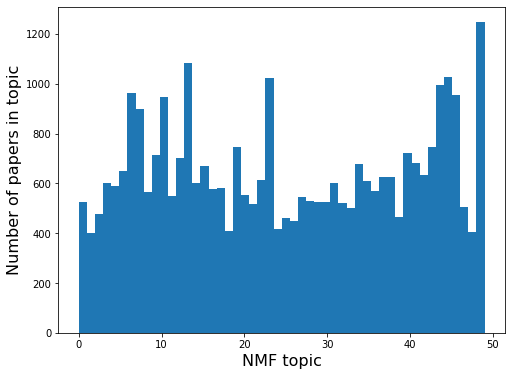

In [ ]:
NMF_cluster0 = H0.argmax(axis=0)
plt.figure(figsize=(8,6))
plt.hist(NMF_cluster0, bins=num_topics0)
plt.xlabel('NMF topic', fontsize=16)
plt.ylabel('Number of papers in topic', fontsize=16)
plt.show()

In [ ]:
# save
with open(os.path.join(DRIVE_PATH,'nextstep', 'NMF_before_20220224.pkl'),'wb') as f:
    pickle.dump((nmf0, W0, H0, idx_to_word0, before_Id), f)

In [ ]:
supertopics_dict_before = dict(zip(before_Id, NMF_cluster0))
supertopic_to_keyword_before = {i:list(idx_to_word0[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W0.T)}
id_to_topicword_before = {id:supertopic_to_keyword0[supertopics_dict0[id]] for id in before_Id}

### NMF level 2

In [ ]:
def run_level2_nmf(vectors, n_subtopics, topic_id, NMF_cluster, idx_to_word):
  nmf = NMF(n_components=n_subtopics, init='random', random_state=0)

  subset = vectors[:, NMF_cluster==topic_id]
  print(subset.shape)
  W = nmf.fit_transform(subset)
  H = nmf.components_

  for i, topic in enumerate(W.transpose()):
    print("Topic {}: {}\n".format(i,", ".join(reversed(idx_to_word[topic.argsort()[-30:].astype(int)]))))
  
  return W, H

def update_subtopics_dict(subtopics_dict, id_to_subtopicword, topic_id, W, sub_NMF_cluster, fields_df_Id, NMF_cluster, idx_to_word):
  subtopics_dict0 = dict(zip(fields_df_Id[NMF_cluster==topic_id], sub_NMF_cluster))
  subtopic_to_keyword0 = {i:list(idx_to_word[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W.T)}
  id_to_subtopicword0 = {id:subtopic_to_keyword0[subtopics_dict0[id]] for id in fields_df_Id[NMF_cluster==topic_id]}
  
  subtopics_dict.update(subtopics_dict0)
  id_to_subtopicword.update(id_to_subtopicword0)


In [ ]:
subtopics_dict_before = {}
id_to_subtopicword_before = {}

ns = [10, 10, 8, 8, 4, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10]
for id, n in enumerate(ns):
  print('====')
  print('topic id', id)
  W, H = run_level2_nmf(vectors0, n, id, NMF_cluster0, idx_to_word0)
  sub_NMF_cluster0 = H.argmax(axis=0)
  update_subtopics_dict(subtopics_dict_before, id_to_subtopicword_before, id, W, sub_NMF_cluster0, before_Id, NMF_cluster0, idx_to_word0)
  

====
topic id 0
(8584, 1643)
Topic 0: model, disease, development, system, discuss, knowledge, animal, science, conceptual, review, many, describe, human, develop, way, structure, introduce, include, propose, representation, domain, developmental, understand, general, focus_on, scientific, basic, feature, consider, apply

Topic 1: analogy, analogical, mapping, model, high_level, describe, similarity, stage, student, computational_model, analogical_reasoning, behaviour, inference, problem, structural, connectionist_model, competitive, extent, incremental, constraint, approximate, experiment, genomics, an_adequate, relational, drama, holyoak, support, pre, people

Topic 2: cognition, model, connectionist, symbolic, connectionist_model, computational, architecture, neural_network, connectionism, different, cognitive, simulation, pdp, localist, learn, simulate, based, human, hybrid, cognitive_science, classical, implementation, paradigm, aspect, provide, fodor, mcclelland, ai, representati

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic 0: action, perception, system, object, control, representation, event, effect, knowledge, human, process, change, execution, language, goal, reason_about, perform, state, problem, describe, provide, description, information, planning, analysis, result, also, evidence, such_as, involve

Topic 1: belief, logic, reason_about, reason, knowledge, update, context, change, belief_revision, represent, logical, epistemic, reasoning, revision, state, set, model, desire, agent, operator, revise, epistemic_logic, provide, allow, believe, sentence, describe, program, hold, problem

Topic 2: logic, semantics, communication, speech_act, commitment, communicative, conversation, protocol, dialogue, language, framework, communicative_act, act, dynamic, pragmatic, meaning, utterance, mental_attitude, deontic, propose, reason_about, based, interaction, mental_state, express, define, conversational, formal, notion, domain

Topic 3: agent, model, notion, cognitive, architecture, environment, bdi, stat

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1616: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  random_state=self.random_state,


Topic 0: learning, model, human, social, process, system, cognitive, framework, discuss, machine, describe, development, language, problem, brain, work, domain, propose, this_article, aspect, provide, discovery, based, action, guide, active, knowledge, generative, area, environment

Topic 1: transfer, instruction, analogy, context, training, concrete, analogical, effect, learn, procedure, strategy, programming, processing, retrieval, experiment, abstract, practice, test, based, problem_solving, concreteness, show, example, problem, task, learned, abstraction, condition, generic, information

Topic 2: child, word, development, object, language, acquisition, linguistic, developmental, meaning, innate, general, acquire, constraint, gesture, language_acquisition, children, read, domain, novel, early, mechanism, school, learn, phonological, conceptual, principle, young_child, cognitive, domain_specific, ability

Topic 3: learn, human, principle, process, mechanism, fact, system, nature, age

In [ ]:
# topics_df0 = pd.DataFrame.from_dict(supertopics_dict0, orient='index',columns=['SupertopicId'])
# topics_df0['SubtopicId'] = topics_df0.index.map(subtopics_dict0)
# topics_df0['SupertopicKeywords'] = topics_df0.index.map(id_to_topicword0)
# topics_df0['SubtopicKeywords'] = topics_df0.index.map(id_to_subtopicword0)

# topics_df0['Super3'] = topics_df0['SupertopicKeywords'].apply(lambda x: ', '.join(x[:3]))
# topics_df0['Sub3'] = topics_df0['SubtopicKeywords'].apply(lambda x: ', '.join(x[:3]))

In [ ]:
topics_df = pd.DataFrame(index = fields_df.Id)
topics_df['SupertopicId_before'] = topics_df.index.map(supertopics_dict_before)
topics_df['SubtopicId_before'] = topics_df.index.map(subtopics_dict_before)
topics_df['SupertopicKeywords_before'] = topics_df.index.map(id_to_topicword_before)
topics_df['SubtopicKeywords_before'] = topics_df.index.map(id_to_subtopicword_before)

In [ ]:
topics_df.head()

,SupertopicId_before,SubtopicId_before,SupertopicKeywords_before,SubtopicKeywords_before
Id,,,,
1999653836,13.0,2.0,"[brain, function, mind, neuroscience, neural]","[network, functional, area, brain, connectivity]"
10833075,NaN,NaN,NaN,NaN
2163480486,9.0,6.0,"[development, review, science, problem, work]","[cell, cellular, protein, molecule, tissue]"
3022532439,2.0,4.0,"[action, agent, motor, social, belief]","[motor, imitation, mirror_neuron, action, repr..."
2439568532,NaN,NaN,NaN,NaN


In [ ]:
# save
with open(os.path.join(DRIVE_PATH,'nextstep', 'topics_df_220122.pkl'),'wb') as f:
    pickle.dump(topics_df,f)

In [ ]:
# with open(os.path.join(DRIVE_PATH, 'topics_df_new.pkl'), 'rb') as file:
#     topics_df = pickle.load(file)

# Topic Modeling on the whole dataset

##Phrase Modeling: Bigram and Trigram Models

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[data_words], min_count=20, threshold=10)
# Faster way to get a sentence clubbed as a trigram/bigram
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(len(bigram.vocab))
print(len(trigram.vocab))
print(len(trigram_mod.phrasegrams))

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


1539348
1661152
5741


In [ ]:
# Define functions for bigrams and trigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
data_words_trigrams = make_trigrams(data_words)
transformed_text = [' '.join(doc) for doc in data_words_trigrams]

## TF-IDF Bag of words

In [ ]:
vectorizer = TfidfVectorizer(stop_words = stopwords_list,
                             max_df = 0.80, #remove words that appear in more than x% of documents
                             min_df = 0.0005, #remove words that appear in less than x% of documents
                             )
vectors = vectorizer.fit_transform(transformed_text).transpose()
print(vectors.shape)
idx_to_word = np.array(vectorizer.get_feature_names()) #dictionary to recover topics

(9098, 59384)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##Hierarchical NMF on Transformed Data

### NMF level 1

In [ ]:
num_topics = 50
nmf0 = NMF(n_components=num_topics, 
           init='random', 
           random_state=2021, 
           max_iter=500, 
           tol=1e-5, 
           alpha=0.01)
W0 = nmf0.fit_transform(vectors)
H0 = nmf0.components_

for i, topic in enumerate(W0.transpose()):
    print("Topic {}: {}\n".format(i,", ".join(reversed(idx_to_word[topic.argsort()[-30:].astype(int)]))))
    print("Topic {}: {}\n".format(i, ", ".join(reversed(np.round(topic[topic.argsort()[-30:].astype(int)], 4).astype(str)))))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic 0: process, involve, unconscious, mental, conscious, psychological, underlie, complex, thinking, understand, dynamic, thought, decision_making, describe, stage, think, role, change, construction, occur, decision, influence, nature, automatic, creative, type, formation, selection, reading, operate

Topic 0: 3.9025, 0.3249, 0.2233, 0.2182, 0.1801, 0.1597, 0.146, 0.1387, 0.1382, 0.1302, 0.1297, 0.129, 0.1265, 0.1178, 0.1122, 0.1114, 0.1022, 0.0977, 0.0926, 0.092, 0.0906, 0.0905, 0.0871, 0.0866, 0.0849, 0.0815, 0.0801, 0.0767, 0.0722, 0.072

Topic 1: communication, signal, communicative, meaning, speech, interaction, message, gesture, communicate, medium, form, receiver, multimodal, mean, discourse, pragmatic, sign, dialogue, share, conversation, semiotic, face, technology, act, speech_act, emergence, symbolic, mode, sender, channel

Topic 1: 3.2813, 0.5407, 0.338, 0.3191, 0.2541, 0.2317, 0.2215, 0.2147, 0.2097, 0.2048, 0.1548, 0.1505, 0.1295, 0.1246, 0.1222, 0.1217, 0.1191, 0.114, 0

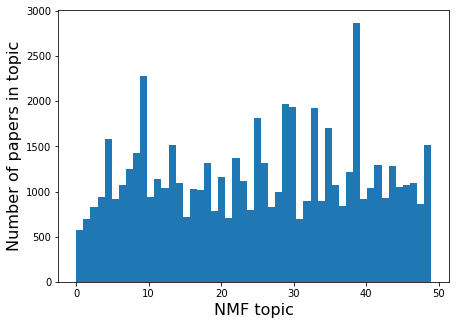

In [ ]:
NMF_cluster = H0.argmax(axis=0)
plt.figure(figsize=(7,5))
plt.hist(NMF_cluster,bins=num_topics)
plt.xlabel('NMF topic', fontsize=16)
plt.ylabel('Number of papers in topic', fontsize=16)
plt.show()

In [ ]:
# save
with open(os.path.join(DRIVE_PATH,'nextstep', 'NMF_all_20220224.pkl'),'wb') as f:
    pickle.dump((nmf0, W0, H0, idx_to_word, fields_df.Id), f)

In [ ]:
supertopics_dict = dict(zip(fields_df.Id,NMF_cluster))
supertopic_to_keyword = {i:list(idx_to_word[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W0.T)}
id_to_topicword = {id:supertopic_to_keyword[supertopics_dict[id]] for id in fields_df.Id}

In [ ]:
{i:", ".join(idx_to_word[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W0.T)}

{0: 'language, linguistic, communication, word, processing',
 1: 'development, science, review, biological, problem',
 2: 'action, agent, motor, perception, movement',
 3: 'human, social, behavior, animal, robot',
 4: 'learning, learn, knowledge, student, learner',
 5: 'memory, work, retrieval, information, event',
 6: 'visual, object, representation, information, spatial',
 7: 'system, complex, information, biological, dynamic',
 8: 'consciousness, conscious, mind, self, experience',
 9: 'model, propose, agent, describe, based',
 10: 'design, creativity, metaphor, creative, game',
 11: 'music, musical, sound, perception, performance',
 12: 'emotion, emotional, agent, affective, affect',
 13: 'cognitive, cognition, process, mind, cognitive_science',
 14: 'brain, network, function, neuroscience, neural'}

### NMF level 2

In [ ]:
# def run_level2_nmf(n_subtopics, topic_id, NMF_cluster):
#   nmf = NMF(n_components=n_subtopics, init='random', random_state=0)

#   subset = vectors[:, NMF_cluster==topic_id]
#   print(subset.shape)
#   W = nmf.fit_transform(subset)
#   H = nmf.components_

#   for i, topic in enumerate(W.transpose()):
#     print("Topic {}: {}\n".format(i,", ".join(reversed(idx_to_word[topic.argsort()[-30:].astype(int)]))))
  
#   return W, H

# def update_subtopics_dict(topic_id, W, sub_NMF_cluster, fields_df, NMF_cluster, idx_to_word):
#   subtopics_dict0 = dict(zip(fields_df.Id[NMF_cluster==topic_id], sub_NMF_cluster))
#   subtopic_to_keyword0 = {i:list(idx_to_word[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W.T)}
#   id_to_subtopicword0 = {id:subtopic_to_keyword0[subtopics_dict0[id]] for id in fields_df.Id[NMF_cluster==topic_id]}
  
#   subtopics_dict.update(subtopics_dict0)
#   id_to_subtopicword.update(id_to_subtopicword0)


In [ ]:
subtopics_dict = {}
id_to_subtopicword = {}

ns = [10, 10, 8, 8, 4, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10]
for id, n in enumerate(ns):
  print('====')
  print('topic id', id)
  W, H = run_level2_nmf(vectors, n, id, NMF_cluster, idx_to_word)
  sub_NMF_cluster0 = H.argmax(axis=0)
  update_subtopics_dict(subtopics_dict, id_to_subtopicword, id, W, sub_NMF_cluster0, fields_df.Id, NMF_cluster, idx_to_word)

====
topic id 0
(9106, 2502)
Topic 0: language, brain, human, cognition, system, cognitive, learning, development, model, function, social, aspect, learn, understand, process, action, role, sign, way, play, show, understanding, influence, describe, spatial, universal, change, behavior, acquire, consider

Topic 1: meaning, word, semantic, language, mean, agent, form, semantics, sentence, structure, game, expression, symbolic, model, show, world, compositional, term, context, utterance, conceptual, call, embodied, account, construction, express, describe, ground, provide, system

Topic 2: processing, language, production, comprehension, network, region, syntactic, process, brain, sentence, area, phonological, aphasia, function, evidence, syntax, involve, language_comprehension, structure, neural, support, model, left, mechanism, review, may, broca, functional, system, level

Topic 3: evolution, language, human, evolutionary, evolve, origin, emergence, capacity, cultural_evolution, hypoth

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1616: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  random_state=self.random_state,


Topic 0: agent, interaction, society, behaviour, artificial_agent, individual, simulation, norm, model, artificial, based, belief, environment, interact_with, game, moral, architecture, affective, ai, commitment, modeling, actor, human, group, collective, like, dynamic, show, goal, action

Topic 1: behavior, behavioral, analysis, evolutionary, individual, environment, psychology, evolution, information, complex, group, model, skinner, perspective, influence, principle, provide, organism, verbal, adaptive, genetic, play, framework, level, understand, goal, cooperation, gene, many, describe

Topic 2: intelligence, ai, artificial_intelligence, machine, intelligent, turing, test, turing_test, ability, general_intelligence, need, artificial, machine_intelligence, artificial_intelligence_ai, computer, multiple, future, discuss, natural, like, question, goal, knowledge, problem, could, define, build, various, many, such_as

Topic 3: social, cognition, network, social_interaction, individual, 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1616: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  random_state=self.random_state,


Topic 0: system, model, cognitive, human, cognition, process, learn, design, develop, provide, social, discuss, general, artificial, development, propose, work, describe, memory, support, learning, suggest, visual, systems, nature, anticipatory, question, mind, action, brain

Topic 1: behavior, function, sensory, environment, body, system, mechanism, functional, motor, neural, principle, physiological, behavioral, organism, animal, brain, many, movement, may, perception, adaptive, review, pattern, auditory, perceptual, role, stimulus, response, understand, integration

Topic 2: complex, complexity, network, science, system, many, behaviour, interaction, understand, social, simple, perspective, phenomenon, interact, systems, emergence, biology, emergent, disease, understanding, chaos, nonlinear, complex_adaptive, natural, element, scientific, may, whole, part, way

Topic 3: biological, biology, system, cell, network, cellular, molecular, organism, function, disease, protein, component, 

In [ ]:
# topics_df = pd.DataFrame.from_dict(supertopics_dict,orient='index',columns=['SupertopicId'])
# topics_df['SubtopicId'] = topics_df.index.map(subtopics_dict)
# topics_df['SupertopicKeywords'] = topics_df.index.map(id_to_topicword)
# topics_df['SubtopicKeywords'] = topics_df.index.map(id_to_subtopicword)

# topics_df['Super3'] = topics_df['SupertopicKeywords'].apply(lambda x: ', '.join(x[:3]))
# topics_df['Sub3'] = topics_df['SubtopicKeywords'].apply(lambda x: ', '.join(x[:3]))

In [ ]:
topics_df['SupertopicId'] = topics_df.index.map(supertopics_dict)
topics_df['SubtopicId'] = topics_df.index.map(subtopics_dict)
topics_df['SupertopicKeywords'] = topics_df.index.map(id_to_topicword)
topics_df['SubtopicKeywords'] = topics_df.index.map(id_to_subtopicword)

In [ ]:
topics_df.head()

,SupertopicId_before,SubtopicId_before,SupertopicKeywords_before,SubtopicKeywords_before,SupertopicId,SubtopicId,SupertopicKeywords,SubtopicKeywords
Id,,,,,,,,
1999653836,13.0,2.0,"[brain, function, mind, neuroscience, neural]","[network, functional, area, brain, connectivity]",14,4,"[brain, network, function, neuroscience, neural]","[network, large_scale, complex, dynamic, graph]"
10833075,NaN,NaN,NaN,NaN,4,3,"[learning, learn, knowledge, student, learner]","[learn, process, mechanism, model, task]"
2163480486,9.0,6.0,"[development, review, science, problem, work]","[cell, cellular, protein, molecule, tissue]",1,5,"[development, science, review, biological, pro...","[protein, biology, biological, function, life]"
3022532439,2.0,4.0,"[action, agent, motor, social, belief]","[motor, imitation, mirror_neuron, action, repr...",2,5,"[action, agent, motor, perception, movement]","[motor, imitation, mirror_neuron, simulation, ..."
2439568532,NaN,NaN,NaN,NaN,9,2,"[model, propose, agent, describe, based]","[explanation, causal, mechanistic, explanatory..."


In [ ]:
'''
# save
with open(os.path.join(DRIVE_PATH,'nextstep', 'topics_df_220122.pkl'),'wb') as f:
    pickle.dump(topics_df,f)
'''

In [ ]:
'''
with open(os.path.join(DRIVE_PATH, 'topics_df_220122.pkl'), 'rb') as file:
    topics_df = pickle.load(file)
'''

# Topic Modeling on After dataset

In [ ]:
data_words_after = [data_words[i] for i in range(fields_df.shape[0]) if fields_df.Y.values[i] >= 2012]
after_Id = fields_df.Id[fields_df.Y.values >= 2012]

##Phrase Modeling: Bigram and Trigram Models

In [ ]:
# Build the bigram models
bigram1 = gensim.models.Phrases(data_words_before, min_count=20, threshold=10) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a bigram
bigram_mod1 = gensim.models.phrases.Phraser(bigram1)
# Build the trigram models
trigram1 = gensim.models.Phrases(bigram_mod1[data_words_after], min_count=20, threshold=10)
# Faster way to get a sentence clubbed as a trigram
trigram_mod1 = gensim.models.phrases.Phraser(trigram1)
print(len(bigram1.vocab))
print(len(trigram1.vocab))
print(len(trigram_mod1.phrasegrams))

997360
951518
2859


In [ ]:
# Define functions for bigrams and trigrams
def make_trigrams1(texts):
    return [trigram_mod1[bigram_mod1[doc]] for doc in texts]

In [ ]:
data_words_trigrams1 = make_trigrams1(data_words_after)
transformed_text1 = [' '.join(doc) for doc in data_words_trigrams1]

## TF-IDF Bag of words

In [ ]:
vectorizer1 = TfidfVectorizer(stop_words = stopwords_list,
                             max_df = 0.80, #remove words that appear in more than x% of documents
                             min_df = 0.0005, #remove words that appear in less than x% of documents
                             )
vectors1 = vectorizer1.fit_transform(transformed_text1).transpose()
print(vectors1.shape)
idx_to_word1 = np.array(vectorizer1.get_feature_names()) #dictionary to recover topics

(8852, 26859)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##Hierarchical NMF on Transformed Data

### NMF level 1

In [ ]:
num_topics1 = 50
nmf1 = NMF(n_components=num_topics1, 
           init='random', 
           random_state=2021, 
           max_iter=500, 
           tol=1e-5, 
           alpha=0.01)
W1 = nmf1.fit_transform(vectors1)
H1 = nmf1.components_

for i, topic in enumerate(W1.transpose()):
    print("Topic {}: {}\n".format(i,", ".join(reversed(idx_to_word1[topic.argsort()[-30:].astype(int)]))))
    print("Topic {}: {}\n".format(i, ", ".join(reversed(np.round(topic[topic.argsort()[-30:].astype(int)], 4).astype(str)))))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic 0: cognitive, ability, cognitive_science, map, framework, control, domain, activity, tool, skill, artifact, capacity, cognitive_architecture, linguistic, modeling, cognitive_linguistics, cognitive_neuroscience, computing, niche, cultural, computational, enhancement, cognitively, level, strategy, resource, problem_solving, operation, engineering, flexibility

Topic 0: 3.131, 0.1417, 0.1187, 0.1115, 0.1102, 0.1041, 0.1039, 0.1, 0.0925, 0.0844, 0.0834, 0.0798, 0.0748, 0.0568, 0.0552, 0.0539, 0.0526, 0.0522, 0.0505, 0.05, 0.048, 0.0473, 0.0466, 0.0451, 0.0418, 0.0417, 0.0408, 0.0408, 0.0398, 0.0388

Topic 1: process, involve, unconscious, mental, dynamic, conscious, level, decision_making, different, complex, underlie, stage, thinking, change, psychological, thought, understand, type, specific, describe, role, decision, creative, processing, occur, insight, consider, construction, individual, nature

Topic 1: 2.8212, 0.239, 0.2, 0.1921, 0.1732, 0.1675, 0.1485, 0.138, 0.1206, 0.1147, 

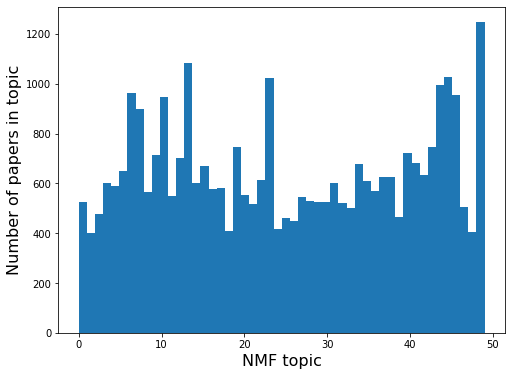

In [ ]:
NMF_cluster1 = H1.argmax(axis=0)
plt.figure(figsize=(8,6))
plt.hist(NMF_cluster0, bins=num_topics1)
plt.xlabel('NMF topic', fontsize=16)
plt.ylabel('Number of papers in topic', fontsize=16)
plt.show()

In [ ]:
# save
with open(os.path.join(DRIVE_PATH,'nextstep', 'NMF_after_20220224.pkl'),'wb') as f:
    pickle.dump((nmf1, W1, H1, idx_to_word1, after_Id), f)

In [ ]:
supertopics_dict_before = dict(zip(before_Id, NMF_cluster0))
supertopic_to_keyword_before = {i:list(idx_to_word0[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W0.T)}
id_to_topicword_before = {id:supertopic_to_keyword0[supertopics_dict0[id]] for id in before_Id}

### NMF level 2

In [ ]:
def run_level2_nmf(vectors, n_subtopics, topic_id, NMF_cluster, idx_to_word):
  nmf = NMF(n_components=n_subtopics, init='random', random_state=0)

  subset = vectors[:, NMF_cluster==topic_id]
  print(subset.shape)
  W = nmf.fit_transform(subset)
  H = nmf.components_

  for i, topic in enumerate(W.transpose()):
    print("Topic {}: {}\n".format(i,", ".join(reversed(idx_to_word[topic.argsort()[-30:].astype(int)]))))
  
  return W, H

def update_subtopics_dict(subtopics_dict, id_to_subtopicword, topic_id, W, sub_NMF_cluster, fields_df_Id, NMF_cluster, idx_to_word):
  subtopics_dict0 = dict(zip(fields_df_Id[NMF_cluster==topic_id], sub_NMF_cluster))
  subtopic_to_keyword0 = {i:list(idx_to_word[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W.T)}
  id_to_subtopicword0 = {id:subtopic_to_keyword0[subtopics_dict0[id]] for id in fields_df_Id[NMF_cluster==topic_id]}
  
  subtopics_dict.update(subtopics_dict0)
  id_to_subtopicword.update(id_to_subtopicword0)


In [ ]:
subtopics_dict_before = {}
id_to_subtopicword_before = {}

ns = [10, 10, 8, 8, 4, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10]
for id, n in enumerate(ns):
  print('====')
  print('topic id', id)
  W, H = run_level2_nmf(vectors0, n, id, NMF_cluster0, idx_to_word0)
  sub_NMF_cluster0 = H.argmax(axis=0)
  update_subtopics_dict(subtopics_dict_before, id_to_subtopicword_before, id, W, sub_NMF_cluster0, before_Id, NMF_cluster0, idx_to_word0)
  

====
topic id 0
(8584, 1643)
Topic 0: model, disease, development, system, discuss, knowledge, animal, science, conceptual, review, many, describe, human, develop, way, structure, introduce, include, propose, representation, domain, developmental, understand, general, focus_on, scientific, basic, feature, consider, apply

Topic 1: analogy, analogical, mapping, model, high_level, describe, similarity, stage, student, computational_model, analogical_reasoning, behaviour, inference, problem, structural, connectionist_model, competitive, extent, incremental, constraint, approximate, experiment, genomics, an_adequate, relational, drama, holyoak, support, pre, people

Topic 2: cognition, model, connectionist, symbolic, connectionist_model, computational, architecture, neural_network, connectionism, different, cognitive, simulation, pdp, localist, learn, simulate, based, human, hybrid, cognitive_science, classical, implementation, paradigm, aspect, provide, fodor, mcclelland, ai, representati

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic 0: action, perception, system, object, control, representation, event, effect, knowledge, human, process, change, execution, language, goal, reason_about, perform, state, problem, describe, provide, description, information, planning, analysis, result, also, evidence, such_as, involve

Topic 1: belief, logic, reason_about, reason, knowledge, update, context, change, belief_revision, represent, logical, epistemic, reasoning, revision, state, set, model, desire, agent, operator, revise, epistemic_logic, provide, allow, believe, sentence, describe, program, hold, problem

Topic 2: logic, semantics, communication, speech_act, commitment, communicative, conversation, protocol, dialogue, language, framework, communicative_act, act, dynamic, pragmatic, meaning, utterance, mental_attitude, deontic, propose, reason_about, based, interaction, mental_state, express, define, conversational, formal, notion, domain

Topic 3: agent, model, notion, cognitive, architecture, environment, bdi, stat

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1616: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  random_state=self.random_state,


Topic 0: learning, model, human, social, process, system, cognitive, framework, discuss, machine, describe, development, language, problem, brain, work, domain, propose, this_article, aspect, provide, discovery, based, action, guide, active, knowledge, generative, area, environment

Topic 1: transfer, instruction, analogy, context, training, concrete, analogical, effect, learn, procedure, strategy, programming, processing, retrieval, experiment, abstract, practice, test, based, problem_solving, concreteness, show, example, problem, task, learned, abstraction, condition, generic, information

Topic 2: child, word, development, object, language, acquisition, linguistic, developmental, meaning, innate, general, acquire, constraint, gesture, language_acquisition, children, read, domain, novel, early, mechanism, school, learn, phonological, conceptual, principle, young_child, cognitive, domain_specific, ability

Topic 3: learn, human, principle, process, mechanism, fact, system, nature, age

In [ ]:
# topics_df0 = pd.DataFrame.from_dict(supertopics_dict0, orient='index',columns=['SupertopicId'])
# topics_df0['SubtopicId'] = topics_df0.index.map(subtopics_dict0)
# topics_df0['SupertopicKeywords'] = topics_df0.index.map(id_to_topicword0)
# topics_df0['SubtopicKeywords'] = topics_df0.index.map(id_to_subtopicword0)

# topics_df0['Super3'] = topics_df0['SupertopicKeywords'].apply(lambda x: ', '.join(x[:3]))
# topics_df0['Sub3'] = topics_df0['SubtopicKeywords'].apply(lambda x: ', '.join(x[:3]))

In [ ]:
topics_df = pd.DataFrame(index = fields_df.Id)
topics_df['SupertopicId_before'] = topics_df.index.map(supertopics_dict_before)
topics_df['SubtopicId_before'] = topics_df.index.map(subtopics_dict_before)
topics_df['SupertopicKeywords_before'] = topics_df.index.map(id_to_topicword_before)
topics_df['SubtopicKeywords_before'] = topics_df.index.map(id_to_subtopicword_before)

In [ ]:
topics_df.head()

,SupertopicId_before,SubtopicId_before,SupertopicKeywords_before,SubtopicKeywords_before
Id,,,,
1999653836,13.0,2.0,"[brain, function, mind, neuroscience, neural]","[network, functional, area, brain, connectivity]"
10833075,NaN,NaN,NaN,NaN
2163480486,9.0,6.0,"[development, review, science, problem, work]","[cell, cellular, protein, molecule, tissue]"
3022532439,2.0,4.0,"[action, agent, motor, social, belief]","[motor, imitation, mirror_neuron, action, repr..."
2439568532,NaN,NaN,NaN,NaN


In [ ]:
# save
with open(os.path.join(DRIVE_PATH,'nextstep', 'topics_df_220122.pkl'),'wb') as f:
    pickle.dump(topics_df,f)

In [ ]:
# with open(os.path.join(DRIVE_PATH, 'topics_df_new.pkl'), 'rb') as file:
#     topics_df = pickle.load(file)